In [7]:
import csv
import cv2
import numpy as np

lines = []
with open("../data/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
        
images = []
measurements = []

for line in lines[1:]:
    for i in range(3):
        source_path = line[i]
        file_name = source_path.split('/')[-1]
        current_path = '../data/IMG/'+file_name
        image = cv2.imread(current_path)
        images.append(image)

        measurement = float(line[3])
        measurements.append(measurement)

# X_train = np.array(images)
# y_train = np.array(measurements)    
        

augmented_images, augmented_measurements = [], []
for image, measurement in zip(images, measurements):
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image,1))#means flipping around y-axis.
    augmented_measurements.append(measurement*-1)

X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)

In [23]:
a = [1,2,3]
b = [4,5,6]
c = []
c.extend([a,b])

c

[[1, 2, 3], [4, 5, 6]]

### how to not be off from the center?

In [38]:
import csv
import cv2
import numpy as np

lines=[]
with open("../data/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
        
car_images, steering_angles = [], []
for row in lines[1:]:

    steering_center = float(row[3])

    # create adjusted steering measurements for the side camera images
    correction = 0.2 # this is a parameter to tune
    steering_left = steering_center + correction
    steering_right = steering_center - correction

    # read in images from center, left and right cameras
    path = "../data/IMG/" # fill in the path to your training IMG directory
    img_center = process_image(np.asarray(Image.open(path + row[0])))
    img_left = process_image(np.asarray(Image.open(path + row[1])))
    img_right = process_image(np.asarray(Image.open(path + row[2])))

    # add images and angles to data set
    car_images.extend([img_center, img_left, img_right])
    steering_angles.extend([steering_center, steering_left, steering_right])


augmented_images, augmented_measurements = [], []
for image, measurement in zip(car_images, steering_angles):
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image,1))#means flipping around y-axis.
    augmented_measurements.append(measurement*-1)

X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)

NameError: name 'process_image' is not defined

In Keras, lambda layers can be used to create arbitrary functions that operate on each image as it passes through the layer.

In this project, a lambda layer is a convenient way to parallelize image normalization. The lambda layer will also ensure that the model will normalize input images when making predictions in drive.py.

In [8]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
# keras 
# from tensorflow.keras import backend as K
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()

model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
#50 rows pixels from the top of the image
#20 rows pixels from the bottom of the image
#0 columns of pixels from the left of the image
#0 columns of pixels from the right of the image
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3))) 
model.add(Convolution2D(6,5,5,activation='relu'))
model.add(MaxPooling2D())
model.add(Convolution2D(6,5,5,activation='relu'))
model.add(MaxPooling2D())          
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(80))
model.add(Dense(1))

model.compile(loss='mse',optimizer='adam')
history = model.fit(X_train, y_train, 
                    validation_split=0.2,
                    shuffle=True,
                    epochs=5)

model.save('model.h5')


Epoch 1/5
402/402 [==============================] - 8s 19ms/step - loss: 0.0166 - val_loss: 0.0135
Epoch 2/5
402/402 [==============================] - 8s 19ms/step - loss: 0.0118 - val_loss: 0.0129
Epoch 3/5
402/402 [==============================] - 8s 19ms/step - loss: 0.0111 - val_loss: 0.0119
Epoch 4/5
402/402 [==============================] - 8s 20ms/step - loss: 0.0107 - val_loss: 0.0121
Epoch 5/5
402/402 [==============================] - 8s 20ms/step - loss: 0.0103 - val_loss: 0.0115


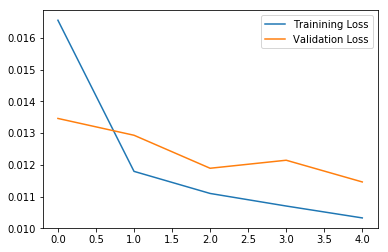

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'], label='Trainining Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

### Validating Your Network
In order to validate your network, you'll want to compare model performance on the training set and a validation set. The validation set should contain image and steering data that was not used for training. A rule of thumb could be to use 80% of your data for training and 20% for validation or 70% and 30%. Be sure to randomly shuffle the data before splitting into training and validation sets.

If model predictions are poor on both the training and validation set (for example, mean squared error is high on both), then this is evidence of underfitting. Possible solutions could be to

* increase the number of epochs
* add more convolutions to the network.

When the model predicts well on the training set but poorly on the validation set (for example, low mean squared error for training set, high mean squared error for validation set), this is evidence of overfitting. If the model is overfitting, a few ideas could be to

* use dropout or pooling layers
* use fewer convolution or fewer fully connected layers
* collect more data or further augment the data set
Ideally, the model will make good predictions on both the training and validation sets. The implication is that when the network sees an image, it can successfully predict what angle was being driven at that moment.